# Step 1: Data acquisition + cleanup

In [1]:
import pandas
import numpy
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as torchtools
from sklearn.model_selection import train_test_split
from scipy.ndimage import gaussian_filter


#Sources: Geek for geeks on set manipulation geeksforgeeks.org/how-to-sort-a-set-of-values-in-python & w3schools.com/python/python_sets.asp

def dataframeToTrainTestSet(dataIn):

    # generating lables (Ys)
    Ys = dataIn['m_label'].to_numpy()
    numberOfSamples = len(Ys)
    possibleOutputs = sorted(set(Ys))
    lableToIndex = { possibleOutputs[i] : i for i in range(len(possibleOutputs)) }
    for i in range(len(Ys)):
        Ys[i] = lableToIndex[Ys[i]]
    del dataIn['m_label']

    #generating pixle data (Xs)
    myArray = dataIn.to_numpy()
    ret1 = numpy.zeros((numberOfSamples,20,20))
    for i in range(numberOfSamples):
        leftOffAt = 0
        for j in range(20):
            for k in range(20):
                ret1[i][j][k] = myArray[i][leftOffAt] / 256
                leftOffAt += 1
    Xs = numpy.reshape(ret1, (-1, 1, 20, 20))

    #split data into testing and training sets
    splitTraingingTesting = train_test_split(Xs, Ys, random_state=1, test_size=0.8)

    train_X = torch.from_numpy(splitTraingingTesting[1])
    train_Y = torch.from_numpy(splitTraingingTesting[3])

    test_X = torch.from_numpy(splitTraingingTesting[0])
    test_Y = torch.from_numpy(splitTraingingTesting[2])

    #converting np arrays to Tensors to TensorDataset
    train = torchtools.TensorDataset(train_X, train_Y)
    test = torchtools.TensorDataset(test_X, test_Y)

    return train, test, { i : possibleOutputs[i] for i in range(len(possibleOutputs)) }

def addedNoiseDataframeToTrainTestSet(dataIn):

    # generating lables (Ys)
    Ys = dataIn['m_label'].to_numpy()
    numberOfSamples = len(Ys)
    possibleOutputs = sorted(set(Ys))
    lableToIndex = { possibleOutputs[i] : i for i in range(len(possibleOutputs)) }
    for i in range(len(Ys)):
        Ys[i] = lableToIndex[Ys[i]]
    del dataIn['m_label']

    #generating pixle data (Xs)
    myArray = dataIn.to_numpy()
    ret1 = numpy.zeros((numberOfSamples,20,20))
    for i in range(numberOfSamples):
        leftOffAt = 0
        for j in range(20):
            for k in range(20):
                ret1[i][j][k] = myArray[i][leftOffAt] / 256
                leftOffAt += 1
    
    Xs = numpy.reshape(ret1, (-1, 1, 20, 20))
    Xs = gaussian_filter(Xs,1)

    #split data into testing and training sets
    splitTraingingTesting = train_test_split(Xs, Ys, random_state=1, test_size=0.8)

    train_X = torch.from_numpy(splitTraingingTesting[1])
    train_Y = torch.from_numpy(splitTraingingTesting[3])

    test_X = torch.from_numpy(splitTraingingTesting[0])
    test_Y = torch.from_numpy(splitTraingingTesting[2])

    #converting np arrays to Tensors to TensorDataset
    train = torchtools.TensorDataset(train_X, train_Y)
    test = torchtools.TensorDataset(test_X, test_Y)

    return train, test, { i : possibleOutputs[i] for i in range(len(possibleOutputs)) }



#Importing data
dataframeELEPHANT = pandas.read_csv('cleanELEPHANT.csv')
dataframeCALIBRI = pandas.read_csv('cleanCALIBRI.csv')
dataframeROMAN = pandas.read_csv('cleanROMAN.csv')

#Cleaning and Preparing data
ELEPHANTdataset = dataframeToTrainTestSet(dataframeELEPHANT)
CALIBRIdataset = dataframeToTrainTestSet(dataframeCALIBRI)
ROMANdataset = dataframeToTrainTestSet(dataframeROMAN)
noisyElephant = addedNoiseDataframeToTrainTestSet(pandas.read_csv('cleanELEPHANT.csv'))

# Step 2: Build a Pytorch network

In [2]:
class Net(nn.Module):
    def __init__(self, possibleOutputs):
        super(Net, self).__init__()
        c1Out = 6
        c2Out = 16
        #input: 20 X 20 image
        self.conv1 = nn.Conv2d(1,c1Out, 3)
        #output: 6: 18 X 18 image
        self.pool = nn.MaxPool2d(2,2)
        #output: 6: 9 X 9 image
        self.conv2 = nn.Conv2d(c1Out, c2Out, 3)
        #output: 16: 7 X 7 image
        #self.pool
        #output: 16: 3 X 3 image

        self.pooledOutputSize = c2Out * 3 * 3
        self.fc1 = nn.Linear(self.pooledOutputSize, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, possibleOutputs)

    def forward(self, x):

        # print(x.shape)

        x = self.pool(F.relu(self.conv1(x)))
        # print(x.shape)

        x = self.pool(F.relu(self.conv2(x)))
        # print(x.shape)

        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        # print(x.shape)

        return x

def train(model, epochs, dataToTrainOn):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    trainloader = torchtools.DataLoader(dataToTrainOn, batch_size=8, shuffle=True, num_workers=0)

    for epoch in range(epochs):

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):

            inputs, labels = data
            optimizer.zero_grad()

            outputs = model(inputs.float())
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 2000 == 1999:
                print('[%d, %5d] Loss: %.3f' % (epoch + 1, i + 1, running_loss/2000))
                running_loss = 0.0
    print('finished training')

def evaluate(model, dataToEvaluate):
    testloader = torchtools.DataLoader(dataToEvaluate, batch_size=8, shuffle=True, num_workers=0)

    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs =model(images.float())
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print('accuracy of the network: %d %%' % (100 * correct/ total))

# Step 3: Exploration and Evaluation

In [3]:
class Net2(nn.Module):
    def __init__(self, possibleOutputs):
        super(Net2, self).__init__()
        c1Out = 48
        c2Out = 128
        
        #input: 20 X 20 image
        self.conv1 = nn.Conv2d(1,c1Out, 3)
    
        self.conv2 = nn.Conv2d(c1Out, c2Out, 3)

        self.conv3 = nn.Conv2d(c2Out, c2Out, 3)
       
        self.pooledOutputSize = c2Out * 14 * 14
        self.fc1 = nn.Linear(self.pooledOutputSize, 400)
        self.fc2 = nn.Linear(400, 250)
        self.fc3 = nn.Linear(250, possibleOutputs)

    def forward(self, x):

        # print(x.shape)

        x = F.relu(self.conv1(x))
        # print(x.shape)

        x = F.relu(self.conv2(x))
        # print(x.shape)

        x = F.relu(self.conv3(x))
        # print(x.shape)


        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        # print(x.shape)

        return x

print('Original Net Results')
net = Net(len(ELEPHANTdataset[2]))
train(net, 5, ELEPHANTdataset[0])
evaluate(net, ELEPHANTdataset[1])

print('Improved Net Results')
net2 = Net2(len(ELEPHANTdataset[2]))
train(net2, 5, ELEPHANTdataset[0])
evaluate(net2, ELEPHANTdataset[1])

print('Testing Different Dataset')
evaluate(net2, ROMANdataset[1])

print('Training on Two Datasets and testing the thrid')
net3 = Net2(len(ROMANdataset[0]))
train(net3, 5, ROMANdataset[0])
train(net3, 5, ELEPHANTdataset[0])
evaluate(net3, CALIBRIdataset[1])

Original Net Results


/usr/local/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


finished training
accuracy of the network: 0 %
Improved Net Results
finished training
accuracy of the network: 40 %
Testing Different Dataset
accuracy of the network: 3 %
Training on Two Datasets and testing the thrid
finished training
finished training
accuracy of the network: 2 %


## With the orignal network we get a value of 0% because the number of masks is too small for a large dataset of 229 features.  With an increased number of masks, removal of pooling layers, and adding an additonal convolution layer we can jump up to 39% accuracy with training over 5 epochs. When attempting to run a different dataset through the network, we only achieve 3% accuracy. However the value is probably much lower and results are difficult to interpret in this case becasue each data set has a different number of charaters and thus a different number of lables. We would have to adjust the data sets to only address letters as opposed to evaluating all charaters in a given font. we would then have to map these 26 different ascii/unicode values to values 0 - 25 in orderd to evaluate different data sets. We can see a similar result when training two different data sets and testing a thrid reslults in only 2% accuracy.

# Step 4: Denoising

## Note: this is not a convolution layer denoiser, just a regualr dense layer neural net...

/usr/local/lib/python3.9/site-packages/torch/nn/functional.py:3609: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


epoch : 1/50, loss = 0.20968927
epoch : 2/50, loss = 0.16986156
epoch : 3/50, loss = 0.14918482
epoch : 4/50, loss = 0.12244392
epoch : 5/50, loss = 0.10860763
epoch : 6/50, loss = 0.10385090
epoch : 7/50, loss = 0.10063307
epoch : 8/50, loss = 0.09838085
epoch : 9/50, loss = 0.09549765
epoch : 10/50, loss = 0.09182000
epoch : 11/50, loss = 0.08717632
epoch : 12/50, loss = 0.08285661
epoch : 13/50, loss = 0.07815312
epoch : 14/50, loss = 0.07409864
epoch : 15/50, loss = 0.07095496
epoch : 16/50, loss = 0.06994063
epoch : 17/50, loss = 0.06818557
epoch : 18/50, loss = 0.06650187
epoch : 19/50, loss = 0.06520341
epoch : 20/50, loss = 0.06426945
epoch : 21/50, loss = 0.06398252
epoch : 22/50, loss = 0.06327800
epoch : 23/50, loss = 0.06226149
epoch : 24/50, loss = 0.06150970
epoch : 25/50, loss = 0.06116983
epoch : 26/50, loss = 0.06015995
epoch : 27/50, loss = 0.05927485
epoch : 28/50, loss = 0.05892678
epoch : 29/50, loss = 0.05796144
epoch : 30/50, loss = 0.05776215
epoch : 31/50, loss

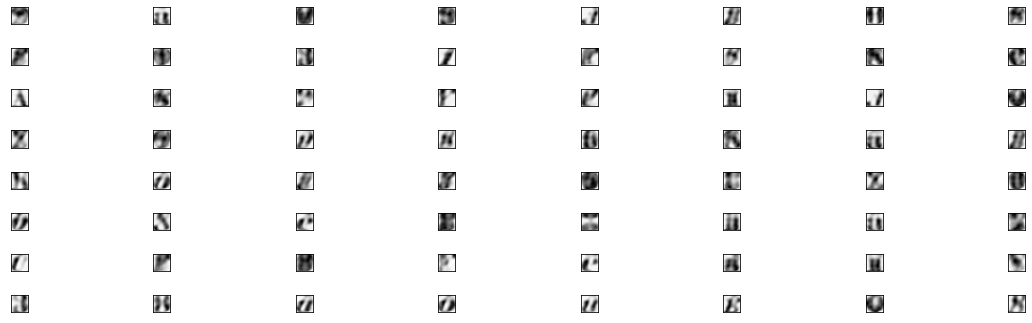

In [17]:
import matplotlib.pyplot as plt

class DenoisingNet(nn.Module):
    def __init__(self):
        super(DenoisingNet, self).__init__()

        self. encodedSize = 32

        self.c1Out = 8
        self.c2Out = 8

        # compression
        self.cv1 = nn.Conv2d(1, self.c1Out, 3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.cv2 = nn.Conv2d(self.c1Out, self.c2Out, 3, padding=1)
        self.downscaledSize = 20//4 #we max pooled twice so we need to divide by 2 twice
        self.flattenSize = self.downscaledSize*self.downscaledSize*self.c2Out
        self.fc1 = nn.Linear(self.flattenSize, 64)
        self.fc2 = nn.Linear(64, self.encodedSize)

        # decompression
        self.fc3 = nn.Linear(self.encodedSize, 64)
        self.fc4 = nn.Linear(64, self.flattenSize)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear')
        self.cv3 = nn.Conv2d(self.c2Out, self.c1Out, 3, padding=1)
        self.cv4 = nn.Conv2d(self.c1Out, 1, 3, padding=1)

    def compress(self, x):
        x = self.cv1(x)

        x = F.relu(self.pool(x))
        
        x = self.cv2(x)

        x = F.relu(self.pool(x))

        x = x.view(-1, self.flattenSize)

        x = F.relu(self.fc1(x))

        x = F.relu(self.fc2(x))

        return x

    def decompress(self, x):
        x = F.relu(self.fc3(x))

        x = F.relu(self.fc4(x))

        x = x.view(-1, self.c2Out, self.downscaledSize, self. downscaledSize)

        x = self.upsample(x)

        x = F.relu(self.cv3(x))

        x = self.cv4(self.upsample(x))

        return x

    def forward(self, x):
        x = self.compress(x)

        x = self.decompress(x)

        return x

def trainDenoiser(model, epochs, dataToTrainOn):
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    criterion = nn.MSELoss()

    train_loader = torchtools.DataLoader(dataToTrainOn, batch_size=8, shuffle=True, num_workers=0)

    for epoch in range(epochs):
        loss = 0

        running_loss = 0

        for i, data in enumerate(train_loader, 0):
            batch_features = data[0]

            optimizer.zero_grad()

            outputs = model(batch_features.float())

            train_loss = criterion(outputs, batch_features.float())

            train_loss.backward()

            optimizer.step()

            loss += train_loss.item()

            running_loss += train_loss.item()
            
            if i % 2000 == 1999:
                print('[%d, %5d] loss: %.8f' % (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

        loss = loss / len(train_loader)

        print("epoch : {}/{}, loss = {:.8f}".format(epoch + 1, epochs, loss))

def drawComparisonEval(model, toEval):
    test_loader = torchtools.DataLoader(toEval, batch_size=8, shuffle=True, num_workers=0)
    plt.figure(figsize=((20,6)))
    for i, batch in enumerate(test_loader):
        if i >= 8: break
        images = batch[0]
        with torch.no_grad():
            reconstructed = model(images.float())
            for j in range(len(images)):
                ax = plt.subplot(16, 8, i*16 + j + 1)
                plt.imshow(images[j].reshape((20,20)), cmap='Greys', interpolation=None)
                ax.get_xaxis().set_visible(False)
                ax.get_yaxis().set_visible(False)

                ax = plt.subplot(16, 8, i*16 + j + 1)
                plt.imshow(reconstructed[j].reshape((20,20)), cmap='Greys', interpolation=None)
                ax.get_xaxis().set_visible(False)
                ax.get_yaxis().set_visible(False)

denosingNet = DenoisingNet()

trainDenoiser(denosingNet, 50, ELEPHANTdataset[0])

drawComparisonEval(denosingNet, noisyElephant[1])